In [21]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import seaborn as sns
import os
import re
import time
import math
from bs4 import BeautifulSoup
import plotly
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

In [22]:
data=pd.read_json('tops_fashion.json')
data.head()

sku        asin product_type_name formatted_price author  \
0  None  B016I2TS4W             SHIRT            None   None   
1  None  B01N49AI08             SHIRT            None   None   
2  None  B01JDPCOHO             SHIRT            None   None   
3  None  B01N19U5H5             SHIRT            None   None   
4  None  B004GSI2OS             SHIRT          $26.26   None   

               color         brand publisher  \
0               None         FNC7C      None   
1               None  FIG Clothing      None   
2               None  FIG Clothing      None   
3               None       Focal18      None   
4  Onyx Black/ Stone   FeatherLite      None   

                          availability  \
0                                 None   
1                                 None   
2                                 None   
3                                 None   
4  Usually ships in 6-10 business days   

                                             reviews  \
0  [False, https://www.amazon.com/reviews/iframe?...   
1  [False, https://www.amazon.com/reviews/iframe?...   
2  [False, https://www.amazon.com/reviews/iframe?...   
3  [True, https://www.amazon.com/reviews/iframe?a...   
4  [False, https://www.amazon.com/reviews/iframe?...   

                                     large_image_url availability_type  \
0  https://images-na.ssl-images-amazon.com/images...              None   
1  https://images-na.ssl-images-amazon.com/images...              None   
2  https://images-na.ssl-images-amazon.com/images...              None   
3  https://images-na.ssl-images-amazon.com/images...              None   
4  https://images-na.ssl-images-amazon.com/images...               now   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                    editorial_review  \
0  Minions Como Superheroes Ironman Women's O Nec...   
1  Sizing runs on the small side. FIG® recommends...   
2  Sizing runs on the small side. FIG® recommends...   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...   
4                                                      

                                               title model  \
0  Minions Como Superheroes Ironman Long Sleeve R...  None   
1                      FIG Clothing Womens Izo Tunic  None   
2                        FIG Clothing Womens Won Top  None   
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  None   
4  Featherlite Ladies' Long Sleeve Stain Resistan...  None   

                                    medium_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

  editorial_reivew  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [23]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is-183138 and Number of features/variables is-19


In [24]:
print('Columns: ',data.columns)

Columns:  Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')


# Missing data from various features

In [26]:
data_nan = (data.isnull().sum() / len(data)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)[:10]
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)

Missing Ratio
author                 99.999454
sku                    99.801789
editorial_review       98.494032
availability           86.604637
availability_type      86.589894

Text(0.5, 1.0, 'Percent missing data by feature')

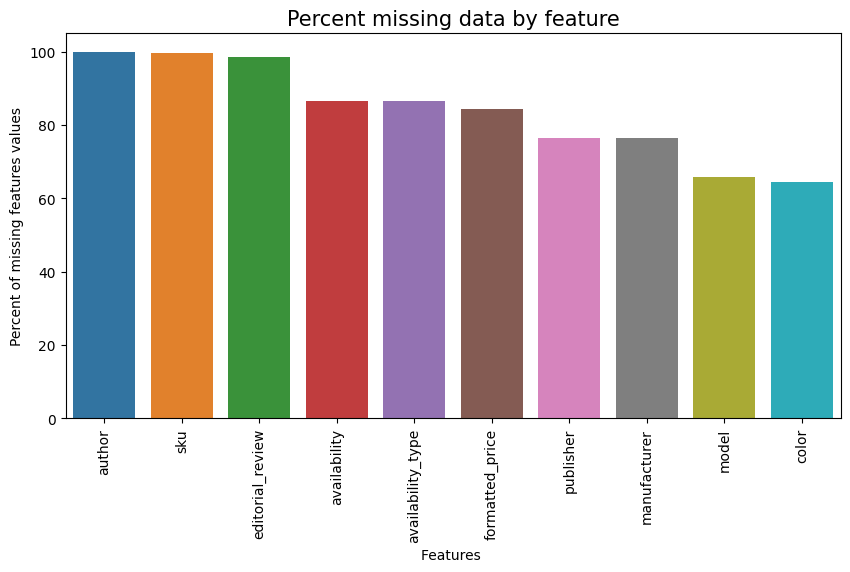

In [29]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=data_nan.index, y=data_nan)
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=15)

In [30]:
data=data[['asin','product_type_name','color','brand','medium_image_url','title','formatted_price']]

In [31]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))
data.head()

Number of data_point is-183138 and Number of features/variables is-7


asin product_type_name              color         brand  \
0  B016I2TS4W             SHIRT               None         FNC7C   
1  B01N49AI08             SHIRT               None  FIG Clothing   
2  B01JDPCOHO             SHIRT               None  FIG Clothing   
3  B01N19U5H5             SHIRT               None       Focal18   
4  B004GSI2OS             SHIRT  Onyx Black/ Stone   FeatherLite   

                                    medium_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

product_type_name

In [38]:
def plot_categories(feature, title1):
    plt.figure(figsize=(15,8))
    count=data[feature].value_counts()
    sns.barplot(x=count[:15].values, y=count[:15].index)
    plt.title(title1,fontsize=15)
    plt.xlabel('Counts', fontsize=13)
    plt.show()

In [14]:
data['product_type_name'].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [20]:
data['product_type_name'].isnull().sum()

0

In [15]:
data['product_type_name'].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [18]:
product_type_count=Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

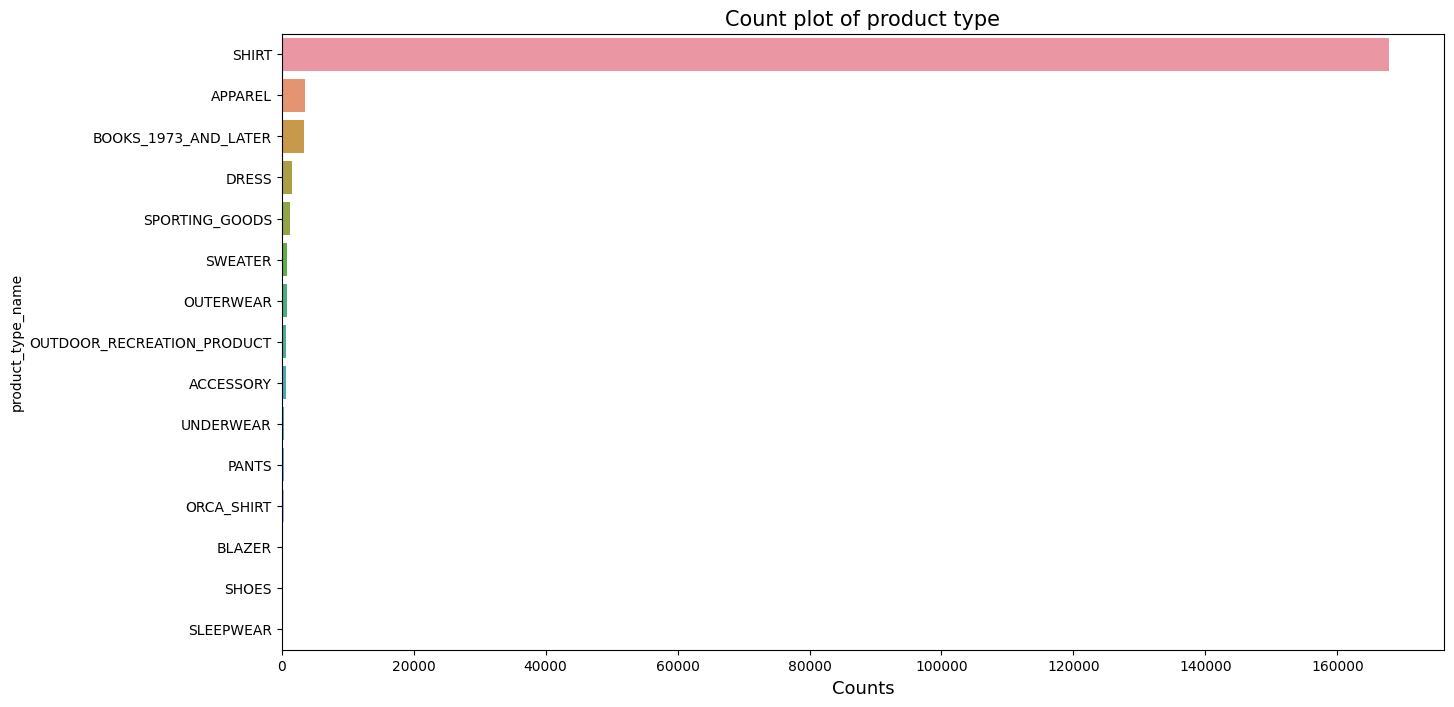

In [39]:
plot_categories('product_type_name', 'Count plot of product type')

Brand

In [24]:
data['brand'].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [27]:
print('Number of NULL Value in Brand Column:-',data['brand'].isnull().sum())

Number of NULL Value in Brand Column:- 151


In [26]:
brand_count=Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

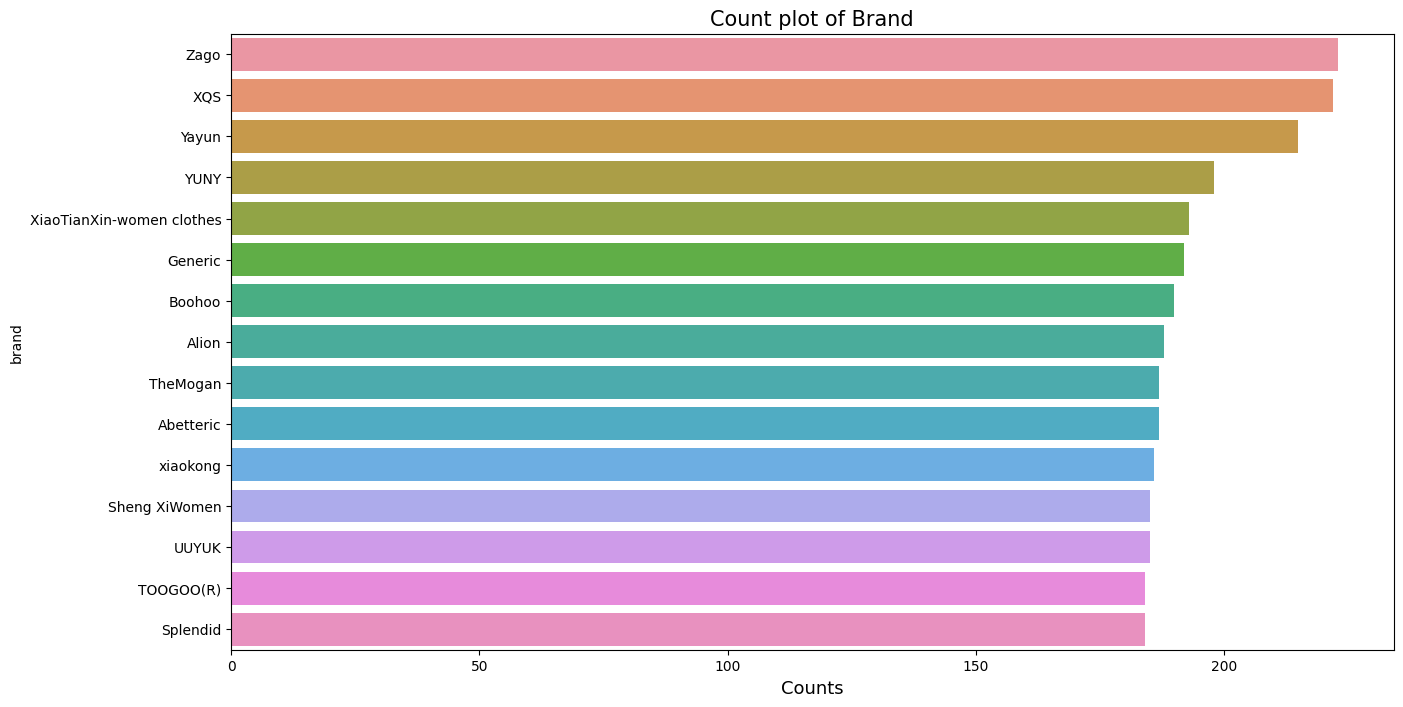

In [40]:
plot_categories('brand', 'Count plot of Brand')

Color

In [41]:
data['color'].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [42]:
print('Number of NULL Value in Color Column is:-',data['color'].isnull().sum())

Number of NULL Value in Color Column is:- 118182


In [43]:
color_count=Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

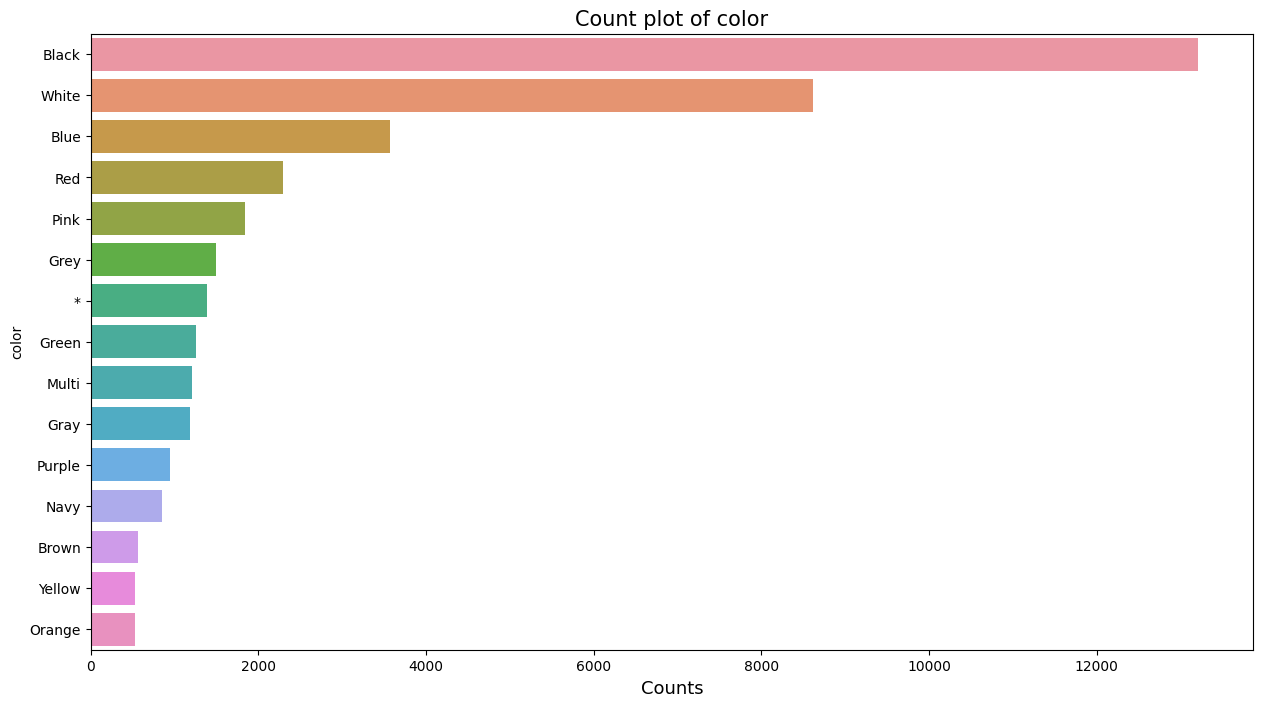

In [44]:
plot_categories('color', 'Count plot of color')

Formatted_price

In [31]:
data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [32]:
print('Number of NULL Values in Formatted_price column is:-',data['formatted_price'].isnull().sum())

Number of NULL Values in Formatted_price column is:- 154743


In [34]:
price_count=Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

Title

In [45]:
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [46]:
print('Number of NULL values in title column is:-',data['title'].isnull().sum())

Number of NULL values in title column is:- 0


In [47]:
title_count=Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [48]:
data.isnull().sum()

asin                      0
product_type_name         0
color                118182
brand                   151
medium_image_url          0
title                     0
formatted_price      154743
dtype: int64

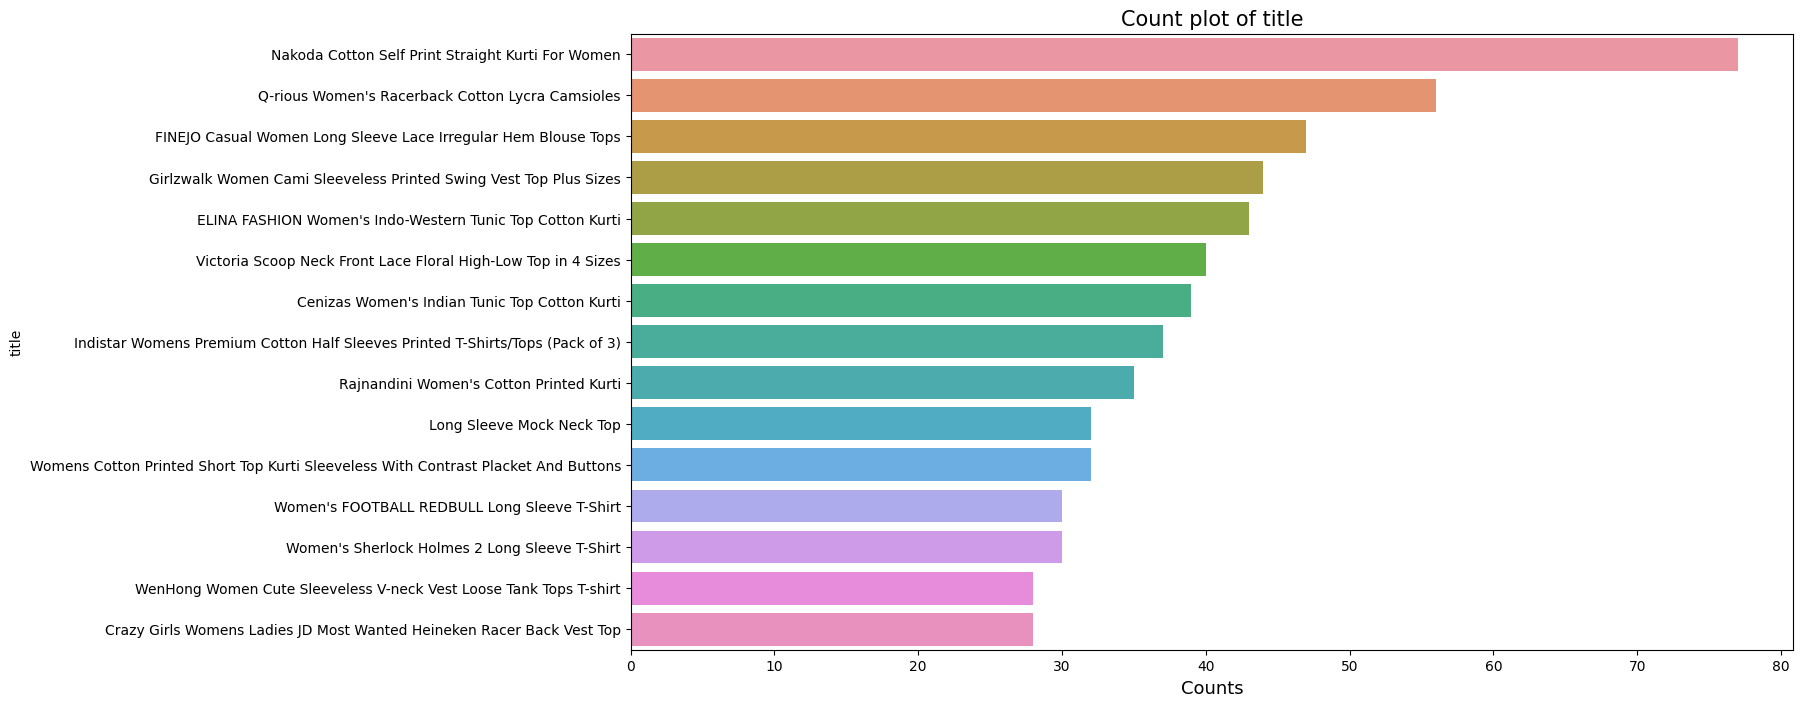

In [49]:
plot_categories('title', 'Count plot of title')

In [50]:
title_count=Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [51]:
data_title_dup1= data[data['title']=='Long Sleeve Mock Neck Top']
data_title_dup1.head()

asin product_type_name  color      brand  \
5988    B00M36E1XG             SHIRT   None  AmeriMark   
171714  B01KZYE3SU             SHIRT   Jade  AmeriMark   
172298  B00KVML9D4             SHIRT   Navy  AmeriMark   
172320  B00KVMQI9O             SHIRT  White  AmeriMark   
172393  B00KVMNT3W             SHIRT   Navy  AmeriMark   

                                         medium_image_url  \
5988    https://images-na.ssl-images-amazon.com/images...   
171714  https://images-na.ssl-images-amazon.com/images...   
172298  https://images-na.ssl-images-amazon.com/images...   
172320  https://images-na.ssl-images-amazon.com/images...   
172393  https://images-na.ssl-images-amazon.com/images...   

                            title formatted_price  
5988    Long Sleeve Mock Neck Top            None  
171714  Long Sleeve Mock Neck Top           $9.99  
172298  Long Sleeve Mock Neck Top          $12.99  
172320  Long Sleeve Mock Neck Top           $9.99  
172393  Long Sleeve Mock Neck Top           $9.99

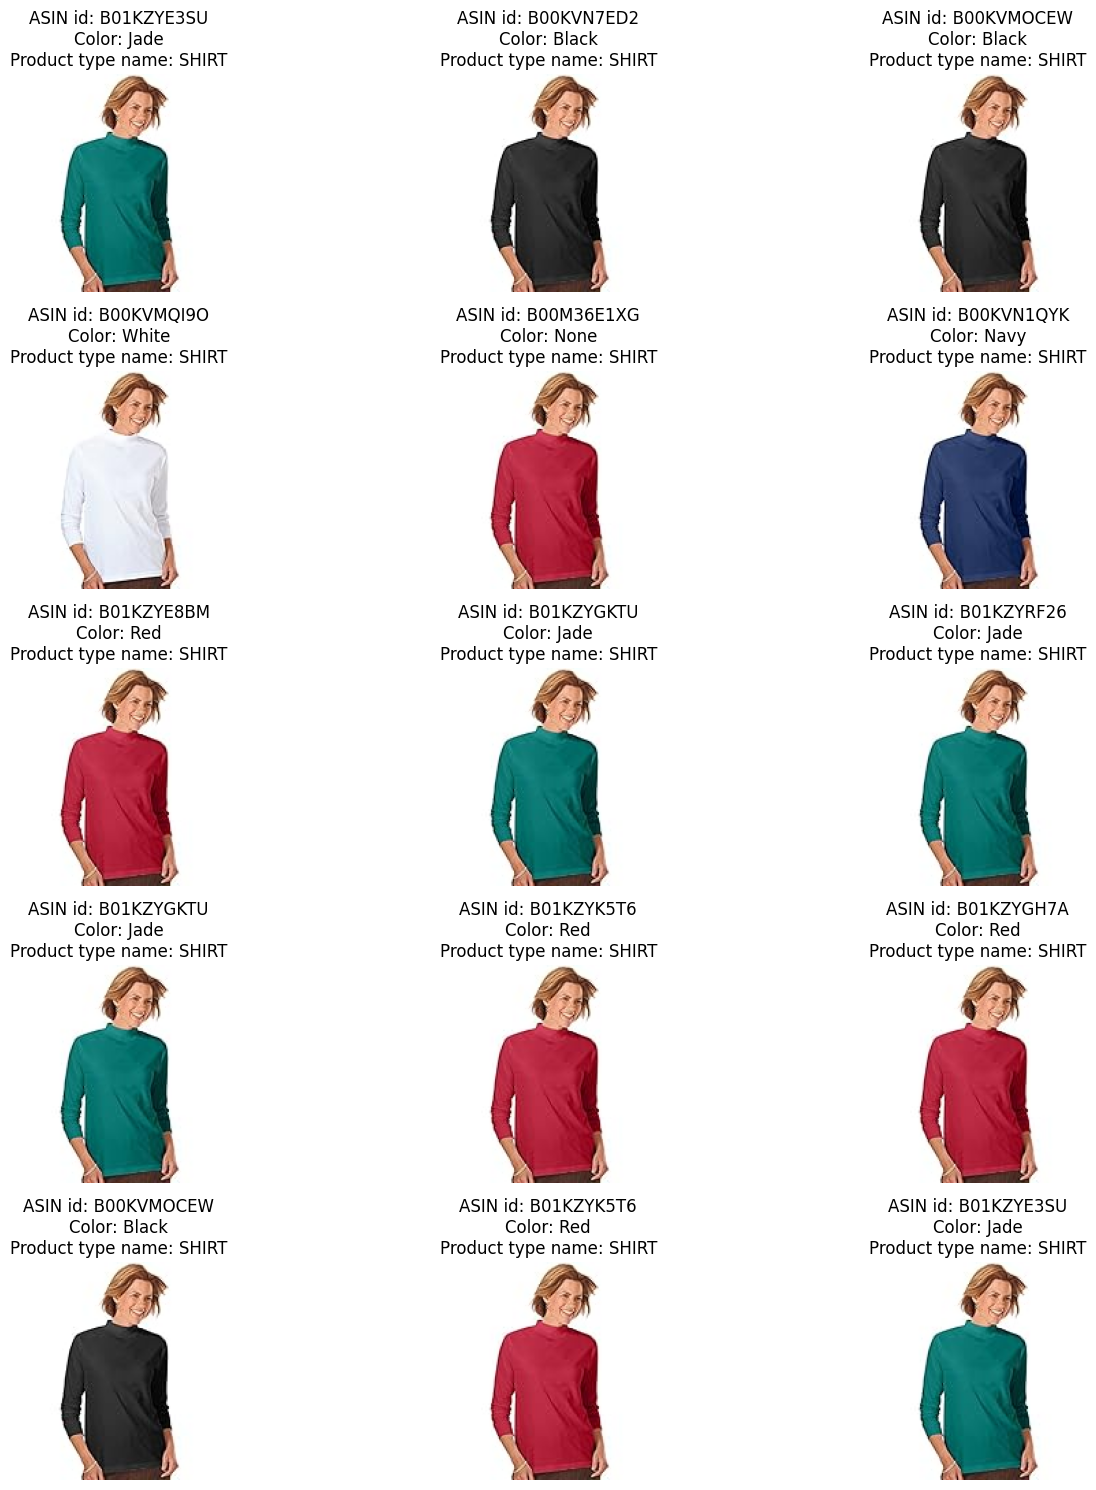

In [52]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 3)
fig.set_size_inches(15, 15)
l = 0

for i in range(5):
    for j in range(3):
        l = rn.randint(0, data_title_dup1.shape[0] - 1)
        label = data_title_dup1.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_title_dup1.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_title_dup1.iloc[l]['asin']), str(data_title_dup1.iloc[l]['color']), str(data_title_dup1.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


In [58]:
data_title_dup1= data[data['title']=='Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)']
data_title_dup1.head()

asin product_type_name   color     brand  \
73029  B0727YFWRM             SHIRT  Maroon  Indistar   
73234  B0725CTC2P             SHIRT   Black  Indistar   
73714  B072BKD5YZ             SHIRT    Blue  Indistar   
73785  B071YWRBRF             SHIRT  Yellow  Indistar   
77477  B071DXHZQT             SHIRT    Blue  Indistar   

                                        medium_image_url  \
73029  https://images-na.ssl-images-amazon.com/images...   
73234  https://images-na.ssl-images-amazon.com/images...   
73714  https://images-na.ssl-images-amazon.com/images...   
73785  https://images-na.ssl-images-amazon.com/images...   
77477  https://images-na.ssl-images-amazon.com/images...   

                                                   title formatted_price  
73029  Indistar Womens Premium Cotton Half Sleeves Pr...            None  
73234  Indistar Womens Premium Cotton Half Sleeves Pr...            None  
73714  Indistar Womens Premium Cotton Half Sleeves Pr...            None  
73785  Indistar Womens Premium Cotton Half Sleeves Pr...            None  
77477  Indistar Womens Premium Cotton Half Sleeves Pr...            None

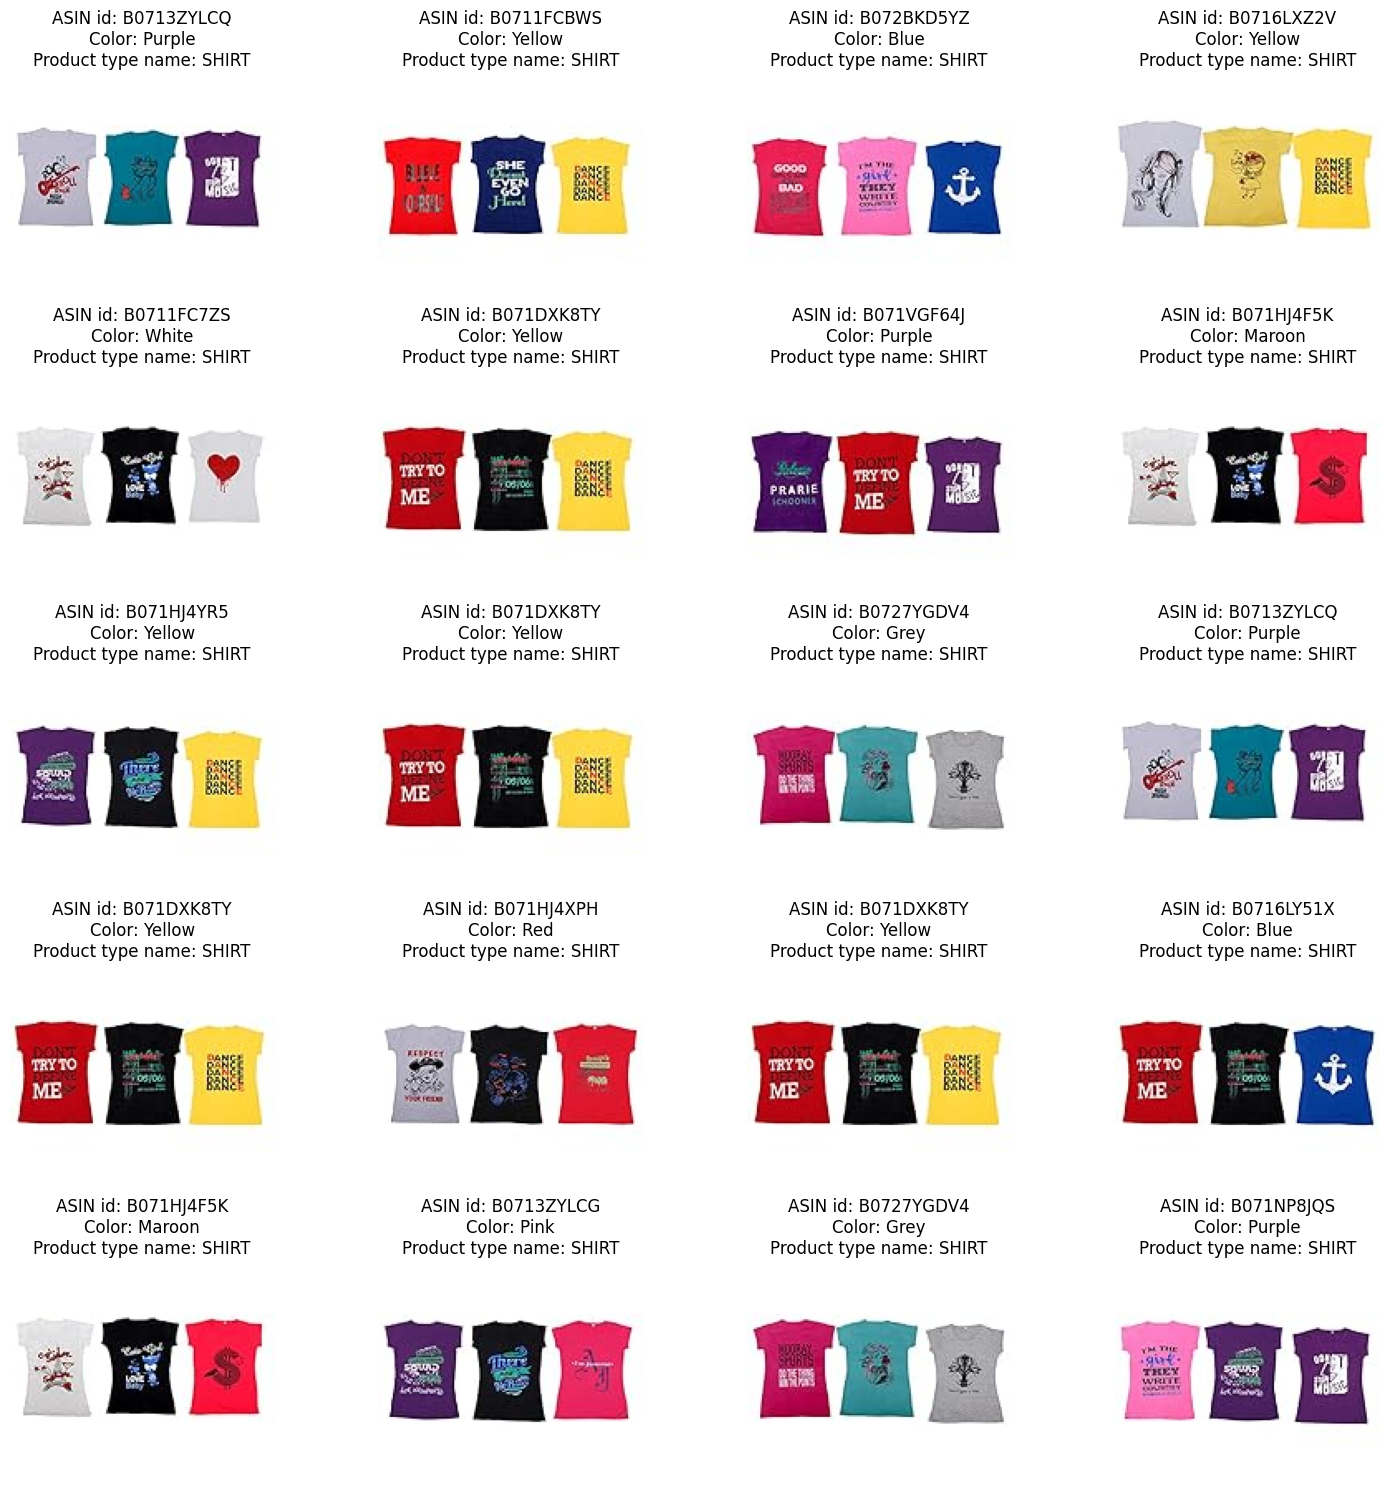

In [59]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)
l = 0

for i in range(5):
    for j in range(4):
        l = rn.randint(0, data_title_dup1.shape[0] - 1)
        label = data_title_dup1.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_title_dup1.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_title_dup1.iloc[l]['asin']), str(data_title_dup1.iloc[l]['color']), str(data_title_dup1.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


In [56]:
data_title_dup1= data[data['title']=="Rajnandini Women's Cotton Printed Kurti"]
data_title_dup1.head()

asin product_type_name color       brand  \
19309  B01LR85DUK             SHIRT  None  Rajnandini   
19455  B01LR838K2             SHIRT  None  Rajnandini   
19709  B01LR8060W             SHIRT  None  Rajnandini   
20753  B01LR84QCG             SHIRT  None  Rajnandini   
23045  B01LR85UVM             SHIRT  None  Rajnandini   

                                        medium_image_url  \
19309  https://images-na.ssl-images-amazon.com/images...   
19455  https://images-na.ssl-images-amazon.com/images...   
19709  https://images-na.ssl-images-amazon.com/images...   
20753  https://images-na.ssl-images-amazon.com/images...   
23045  https://images-na.ssl-images-amazon.com/images...   

                                         title formatted_price  
19309  Rajnandini Women's Cotton Printed Kurti            None  
19455  Rajnandini Women's Cotton Printed Kurti            None  
19709  Rajnandini Women's Cotton Printed Kurti            None  
20753  Rajnandini Women's Cotton Printed Kurti            None  
23045  Rajnandini Women's Cotton Printed Kurti            None

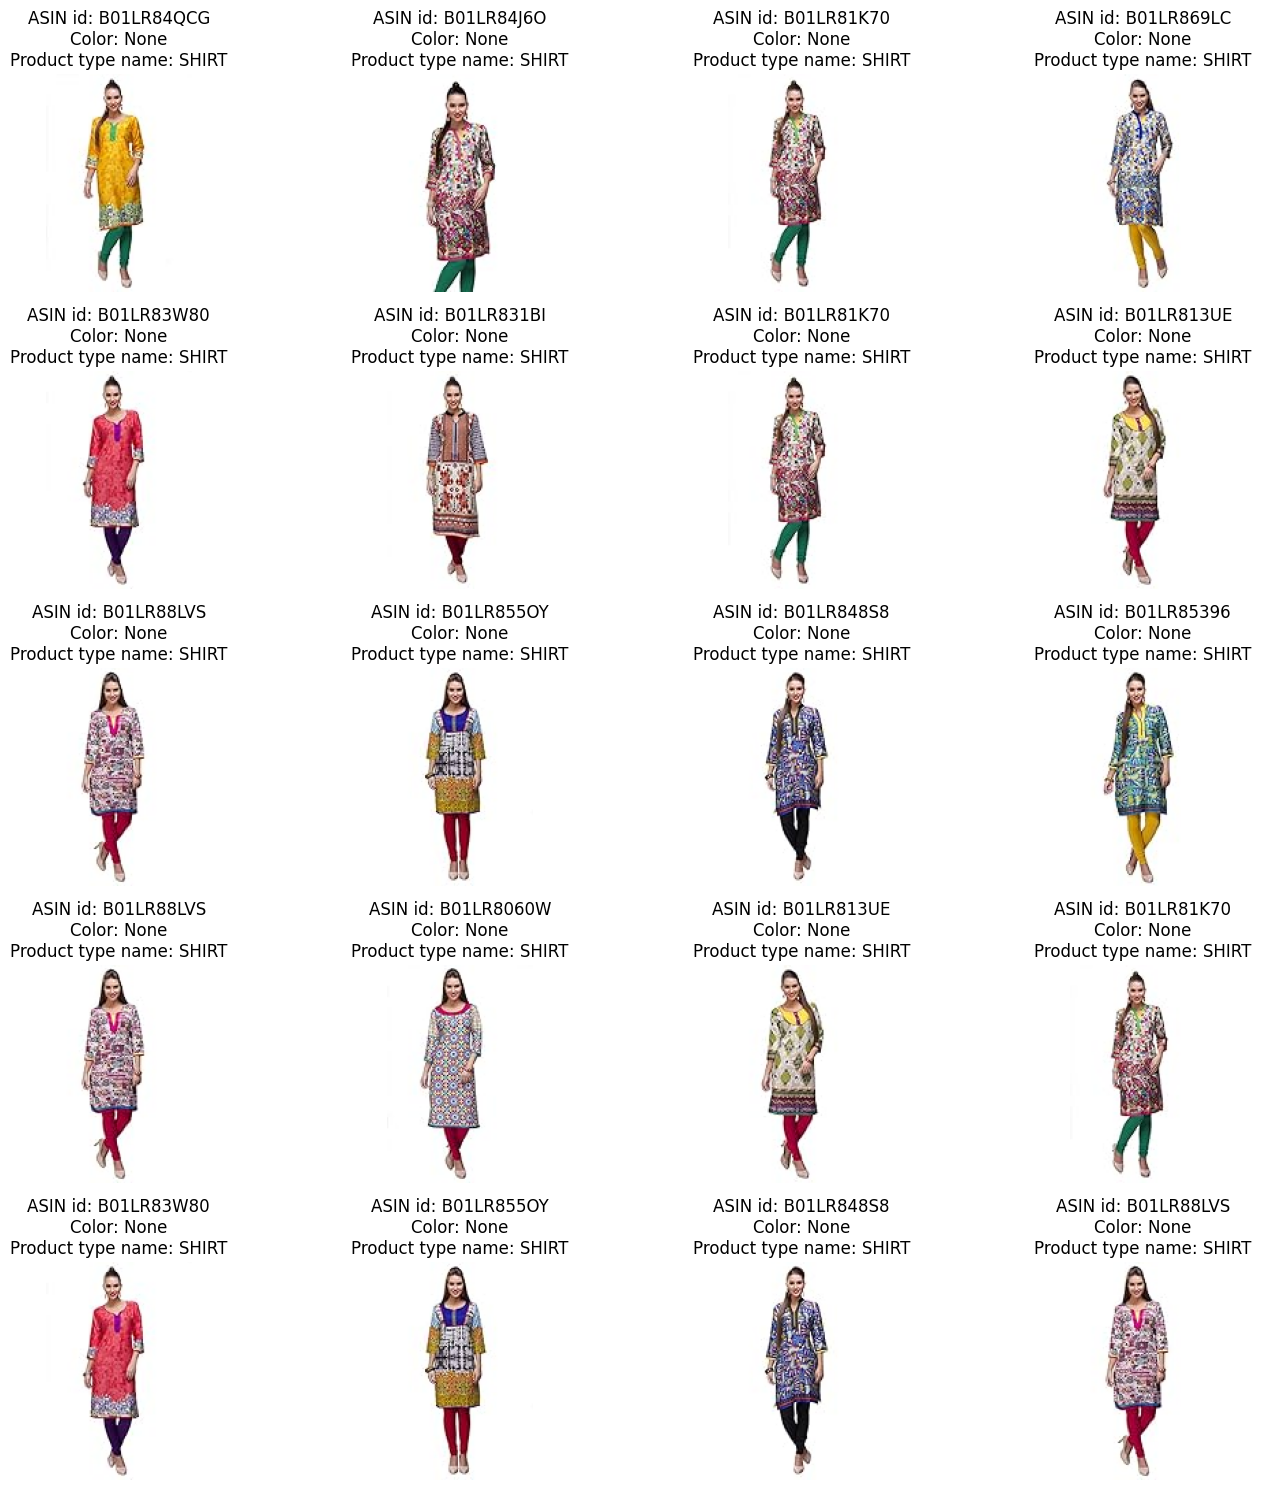

In [57]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)
l = 0

for i in range(5):
    for j in range(4):
        l = rn.randint(0, data_title_dup1.shape[0] - 1)
        label = data_title_dup1.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_title_dup1.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_title_dup1.iloc[l]['asin']), str(data_title_dup1.iloc[l]['color']), str(data_title_dup1.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


In [60]:
data_title_dup1= data[data['title']=="FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops"]
data_title_dup1.head()

asin product_type_name      color     brand  \
67561  B01HAAYQLQ             SHIRT        Red  Jooniyaa   
71332  B01HAAZMGO             SHIRT  Black New  Jooniyaa   
74371  B01HAAYRZ6             SHIRT        Red  Jooniyaa   
75222  B01HAAYXWI             SHIRT  Navy Blue  Jooniyaa   
75444  B01H3YWENG             SHIRT      Black  Jooniyaa   

                                        medium_image_url  \
67561  https://images-na.ssl-images-amazon.com/images...   
71332  https://images-na.ssl-images-amazon.com/images...   
74371  https://images-na.ssl-images-amazon.com/images...   
75222  https://images-na.ssl-images-amazon.com/images...   
75444  https://images-na.ssl-images-amazon.com/images...   

                                                   title formatted_price  
67561  FINEJO Casual Women Long Sleeve Lace Irregular...          $19.97  
71332  FINEJO Casual Women Long Sleeve Lace Irregular...          $19.92  
74371  FINEJO Casual Women Long Sleeve Lace Irregular...          $19.96  
75222  FINEJO Casual Women Long Sleeve Lace Irregular...          $19.91  
75444  FINEJO Casual Women Long Sleeve Lace Irregular...          $19.93

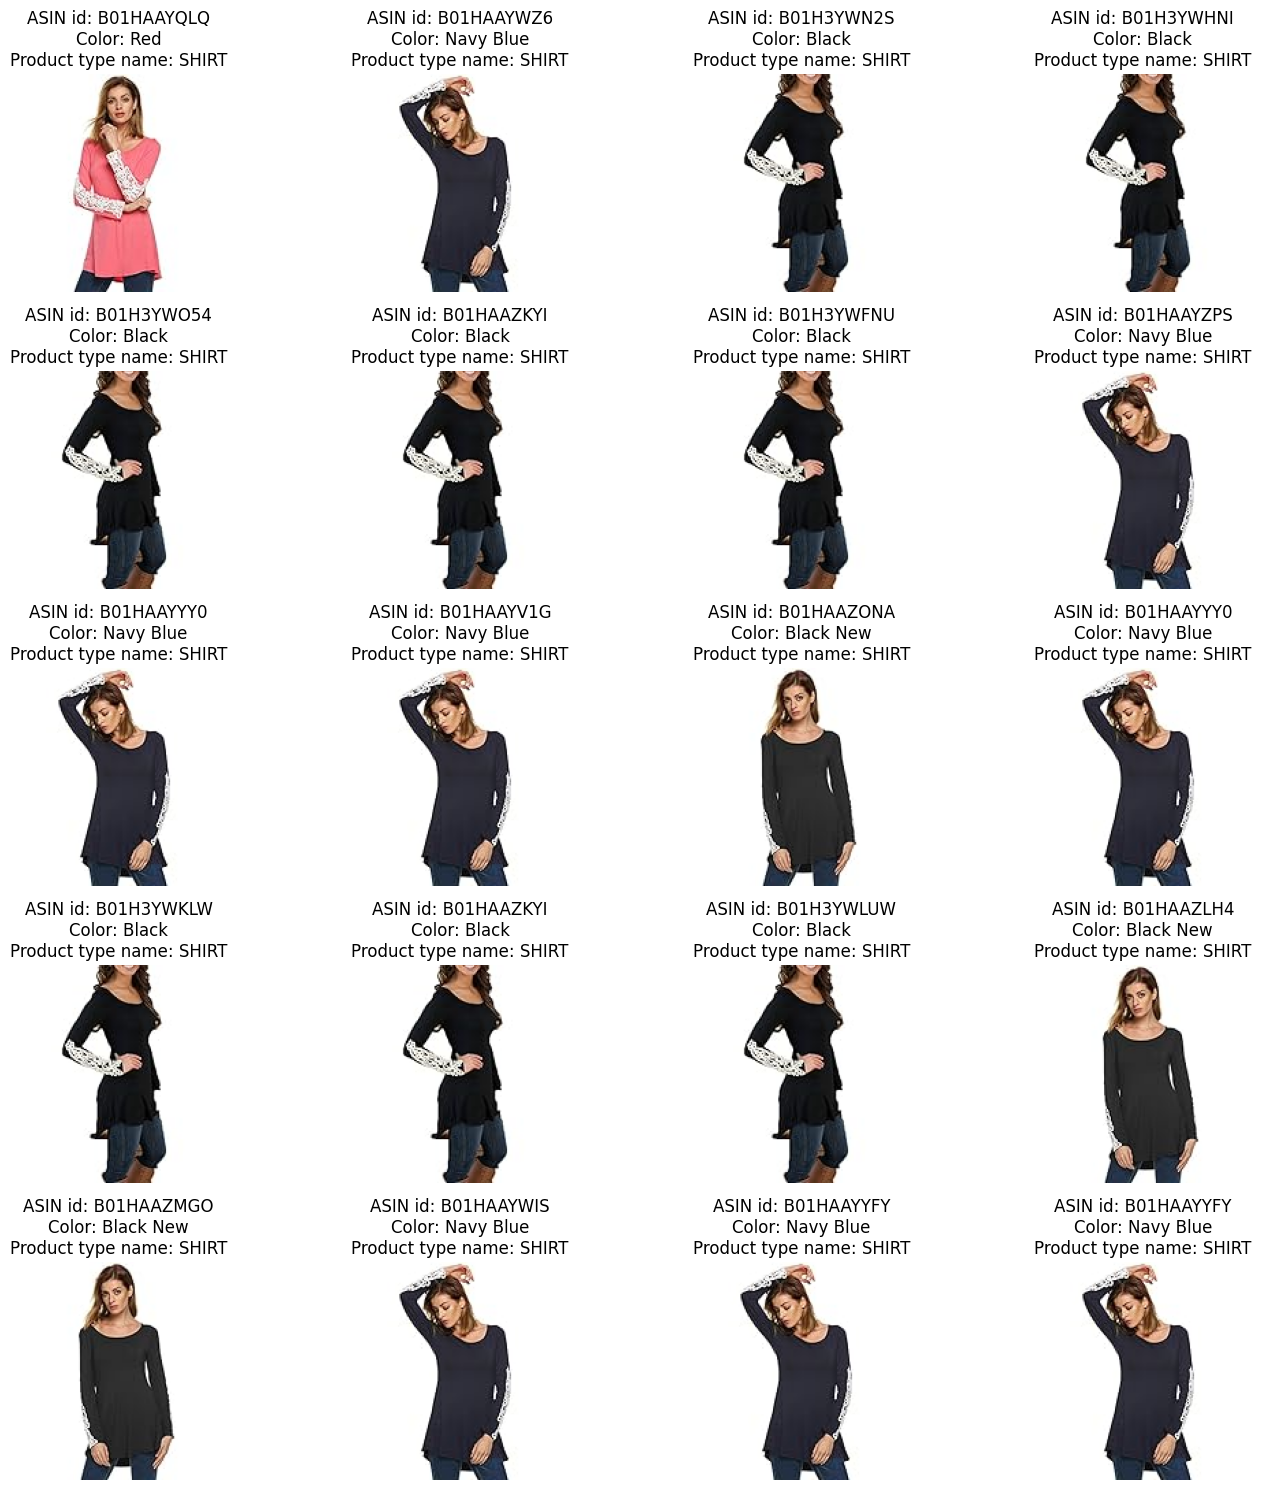

In [61]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)
l = 0

for i in range(5):
    for j in range(4):
        l = rn.randint(0, data_title_dup1.shape[0] - 1)
        label = data_title_dup1.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_title_dup1.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_title_dup1.iloc[l]['asin']), str(data_title_dup1.iloc[l]['color']), str(data_title_dup1.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


In [40]:
data.to_pickle('new_duplicate/180k_apperal_data')

#  Data Preprocessing

In [42]:
data=data.loc[~(data['formatted_price'].isnull())]

In [43]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is-28395 and Number of features/variables is-7


In [44]:
data=data.loc[~(data['color'].isnull())]

In [45]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is-28385 and Number of features/variables is-7


In [46]:
data.to_pickle('new_duplicate/28k_apperal_data')

# Remove Near Duplicate Items

In [3]:
data=pd.read_pickle('new_duplicate/28k_apperal_data')

In [4]:
print(sum(data.duplicated('title')))

2325


In [5]:
data=data[data['title'].apply(lambda x:len(x.split())>4)]

In [6]:
print('Number of data_point is:-{} and Number of features/variables is:-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is:-27949 and Number of features/variables is:-7


In [7]:
data.sort_values('title',inplace=True,ascending=False)
data.head()

asin product_type_name        color     brand  \
61973   B06Y1KZ2WB             SHIRT   Black/Pink    Éclair   
133820  B010RV33VE             SHIRT         Pink  xiaoming   
81461   B01DDSDLNS             SHIRT        White  xiaoming   
75995   B00X5LYO9Y             SHIRT  Red Anchors  xiaoming   
151570  B00WPJG35K             SHIRT        White  xiaoming   

                                         medium_image_url  \
61973   https://images-na.ssl-images-amazon.com/images...   
133820  https://images-na.ssl-images-amazon.com/images...   
81461   https://images-na.ssl-images-amazon.com/images...   
75995   https://images-na.ssl-images-amazon.com/images...   
151570  https://images-na.ssl-images-amazon.com/images...   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [8]:
indices=[]
for i,row in data.iterrows():
    indices.append(i)

In [9]:
import itertools
stage1_duplicate=[]
i=0
j=0
num_data_point=data.shape[0]
while i<num_data_point and j<num_data_point:
    previous=i
    a=data['title'].loc[indices[i]].split()
    j=i+1
    while j<num_data_point:
        b=data['title'].loc[indices[j]].split()
        length=max(len(a),len(b))
        count=0
        for k in itertools.zip_longest(a,b):
            if (k[0]==k[1]):
                count+=1
        if (length-count)>2:
            stage1_duplicate.append(data['asin'].loc[indices[i]])
            i=j
            break
        else:
            j+=1
    if previous==i:
        break

In [10]:
data=data.loc[data['asin'].isin(stage1_duplicate)]

In [11]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is-17592 and Number of features/variables is-7


In [12]:
data.to_pickle('new_duplicate/17k_apperal_data')

2nd Type of removing Duplicates

In [62]:
indices=[]
for i,row in data.iterrows():
    indices.append(i)

In [ ]:
import itertools
stage2_duplicate=[]
while len(indices)!=0:
    i=indices.pop()
    stage2_duplicate.append(data['asin'].loc[i])
    a=data['title'].loc[i].split()
    for j in indices:
        b=data['title'].loc[j].split()
        length=max(len(a),len(b))
        count=0
        for k in itertools.zip_longest(a,b):
            if k[0]==k[1]:
                count+=1
        if length-count<3:
            indices.remove(j)

In [ ]:
data=data.loc[data['asin'].isin(stage2_duplicate)]

# Text Pre_processing

In [13]:
data=pd.read_pickle('new_duplicate/17k_apperal_data')
data.head()

asin product_type_name        color     brand  \
61973   B06Y1KZ2WB             SHIRT   Black/Pink    Éclair   
133820  B010RV33VE             SHIRT         Pink  xiaoming   
81461   B01DDSDLNS             SHIRT        White  xiaoming   
75995   B00X5LYO9Y             SHIRT  Red Anchors  xiaoming   
151570  B00WPJG35K             SHIRT        White  xiaoming   

                                         medium_image_url  \
61973   https://images-na.ssl-images-amazon.com/images...   
133820  https://images-na.ssl-images-amazon.com/images...   
81461   https://images-na.ssl-images-amazon.com/images...   
75995   https://images-na.ssl-images-amazon.com/images...   
151570  https://images-na.ssl-images-amazon.com/images...   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [14]:
stop_words=set(stopwords.words('english'))
print('Stop_words is:-',stop_words)

Stop_words is:- {'don', 'i', 'and', "it's", 'm', 'until', 'having', 'd', 'here', 'them', 'as', "should've", "aren't", "isn't", 'too', 'doesn', 'hers', "wouldn't", "haven't", 'y', 'same', "you're", 'hadn', 'whom', 'has', 'he', 'then', 'during', 'than', 'further', 'have', 'me', 'we', "weren't", 'to', 'on', "don't", "hadn't", 'should', 'this', 've', 'himself', 'wasn', 'my', 'were', 'can', 'mustn', "won't", 'out', 'with', 'any', 'where', "mustn't", 'the', 'some', 'which', 'her', 'by', 'below', 'all', "shouldn't", 'themselves', 'ourselves', 'she', 'in', 'few', 'll', 'for', 't', 'hasn', 'yourselves', 'own', 'more', 'there', 'doing', "wasn't", 'had', 'not', 'are', 'or', 'you', 'against', 'just', 'aren', 'myself', 'its', 'both', "mightn't", 'it', 'now', 'who', 'shouldn', 'a', 'be', 'did', 'ma', "you'd", "didn't", 'up', 'from', 'over', 'why', 'at', 'down', 'they', 'when', 'shan', 'that', 'while', 'our', 'these', 're', 'ours', 'through', "shan't", 'after', 'theirs', 'is', 'o', 'each', 'no', 'cou

In [21]:
t1=time.time()
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        for words in total_text.split():
            word=("".join(e for e in words if e.isalnum()))
            word=word.lower()
            if not word in stop_words:
                string+=words+" "
        data[column][index]=string
for index,row in data.iterrows():
    nlp_preprocessing(row['title'],index,'title')
t2=time.time()
print('Time to run code is:-{} secs'.format(t2-t1))

Time to run code is:-31.523692846298218 secs


In [22]:
from nltk.stem.porter import PorterStemmer
stemmer=PorterStemmer()
print(stemmer.stem('arguing'))

argu


In [3]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
43    featherlite ladies silky smooth pique white xl           $13.53

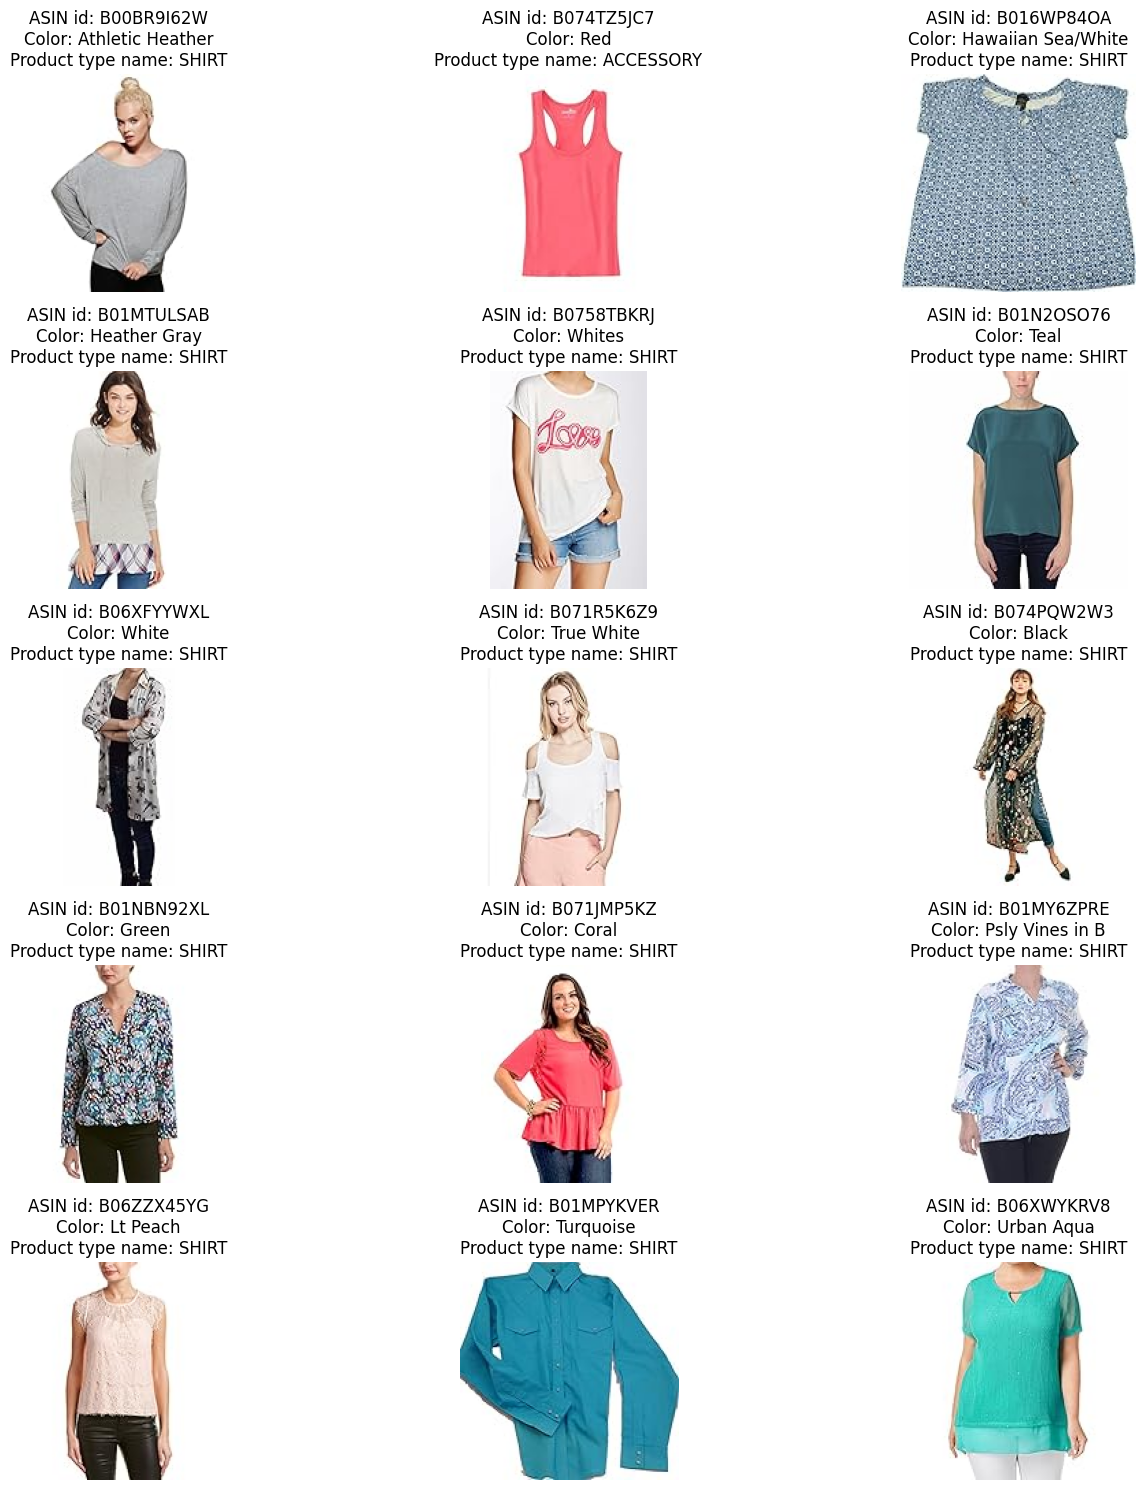

In [18]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 3)
fig.set_size_inches(15, 15)
l = 0

for i in range(5):
    for j in range(3):
        l = rn.randint(0, data.shape[0] - 1)
        label = data.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data.iloc[l]['asin']), str(data.iloc[l]['color']), str(data.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


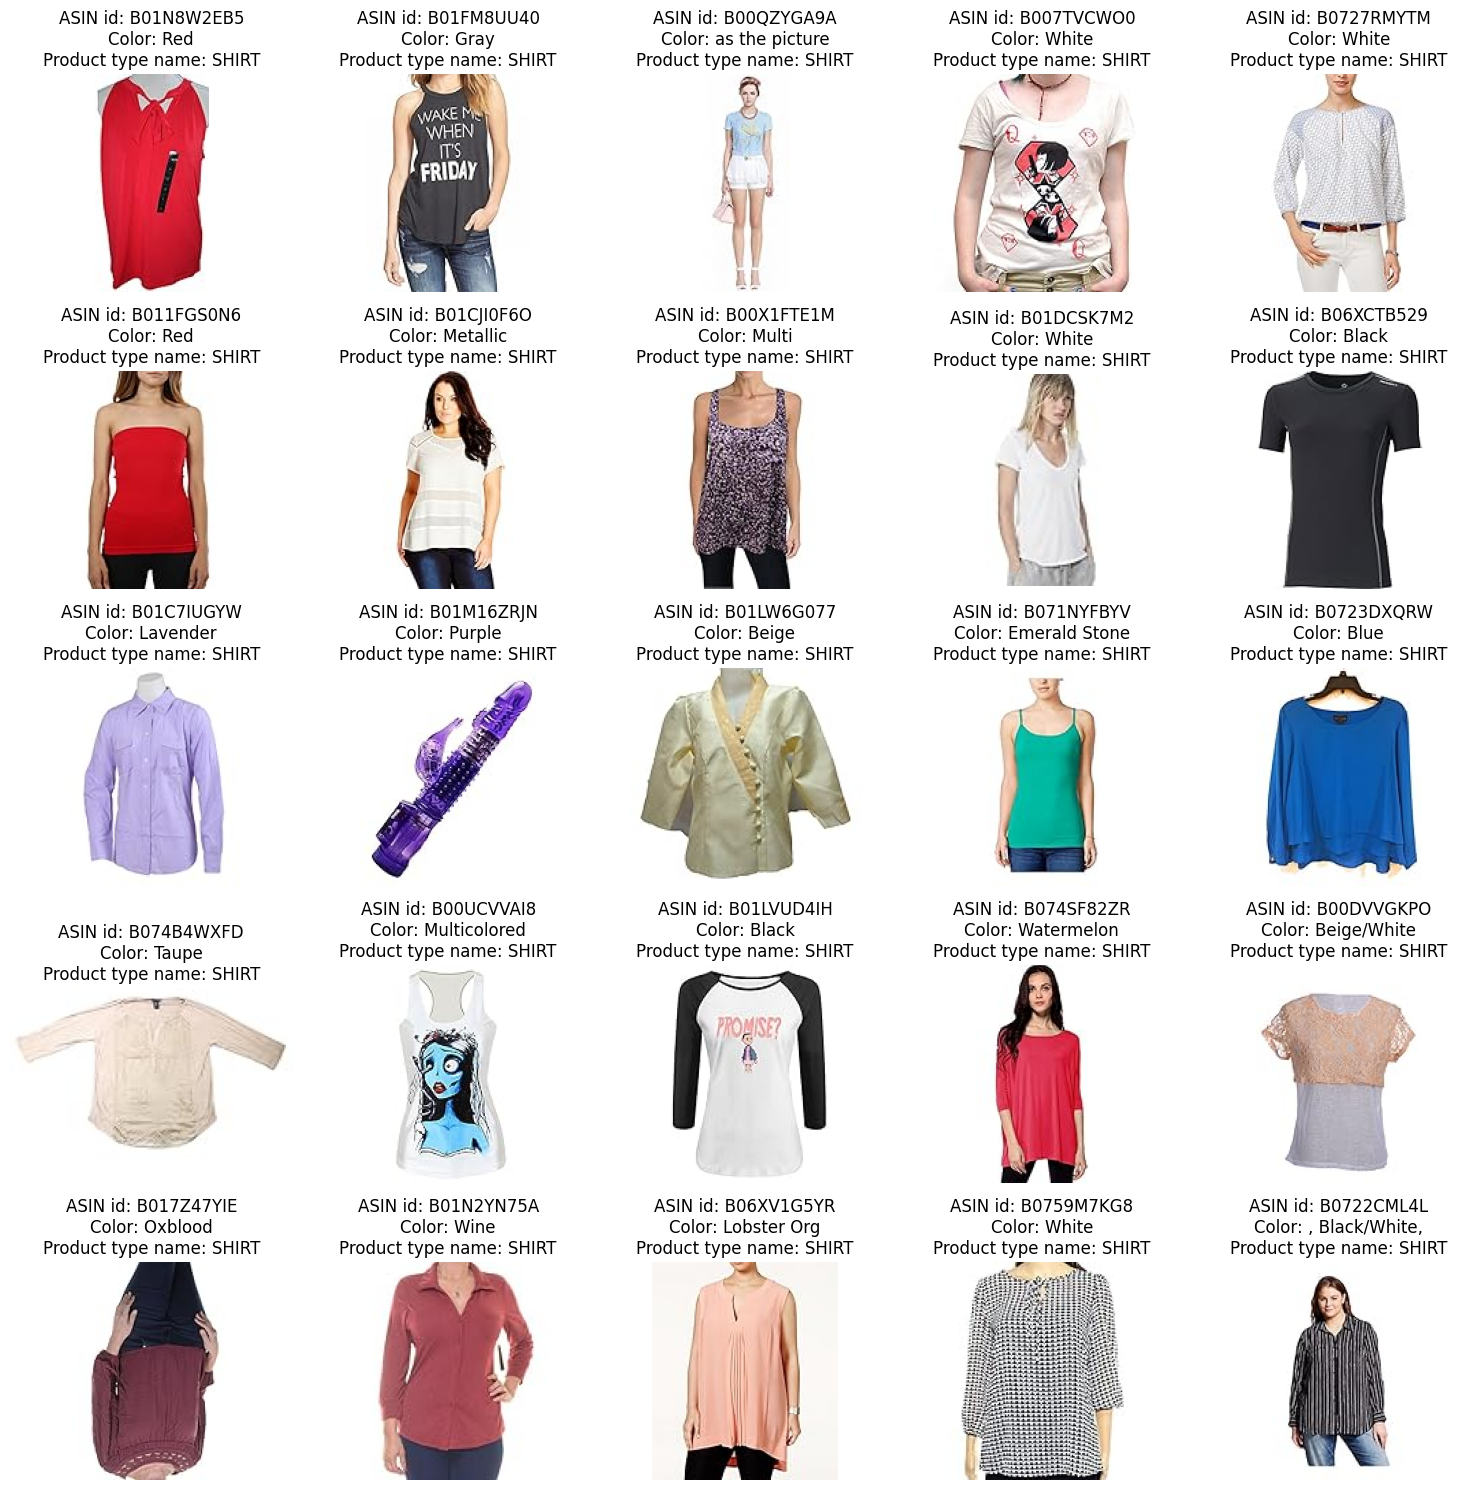

In [20]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(15, 15)
l = 0
data_shirt = data[data['product_type_name']=='SHIRT']
for i in range(5):
    for j in range(5):
        l = rn.randint(0, data_shirt.shape[0] - 1)
        label = data_shirt.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_shirt.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_shirt.iloc[l]['asin']), str(data_shirt.iloc[l]['color']), str(data_shirt.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()


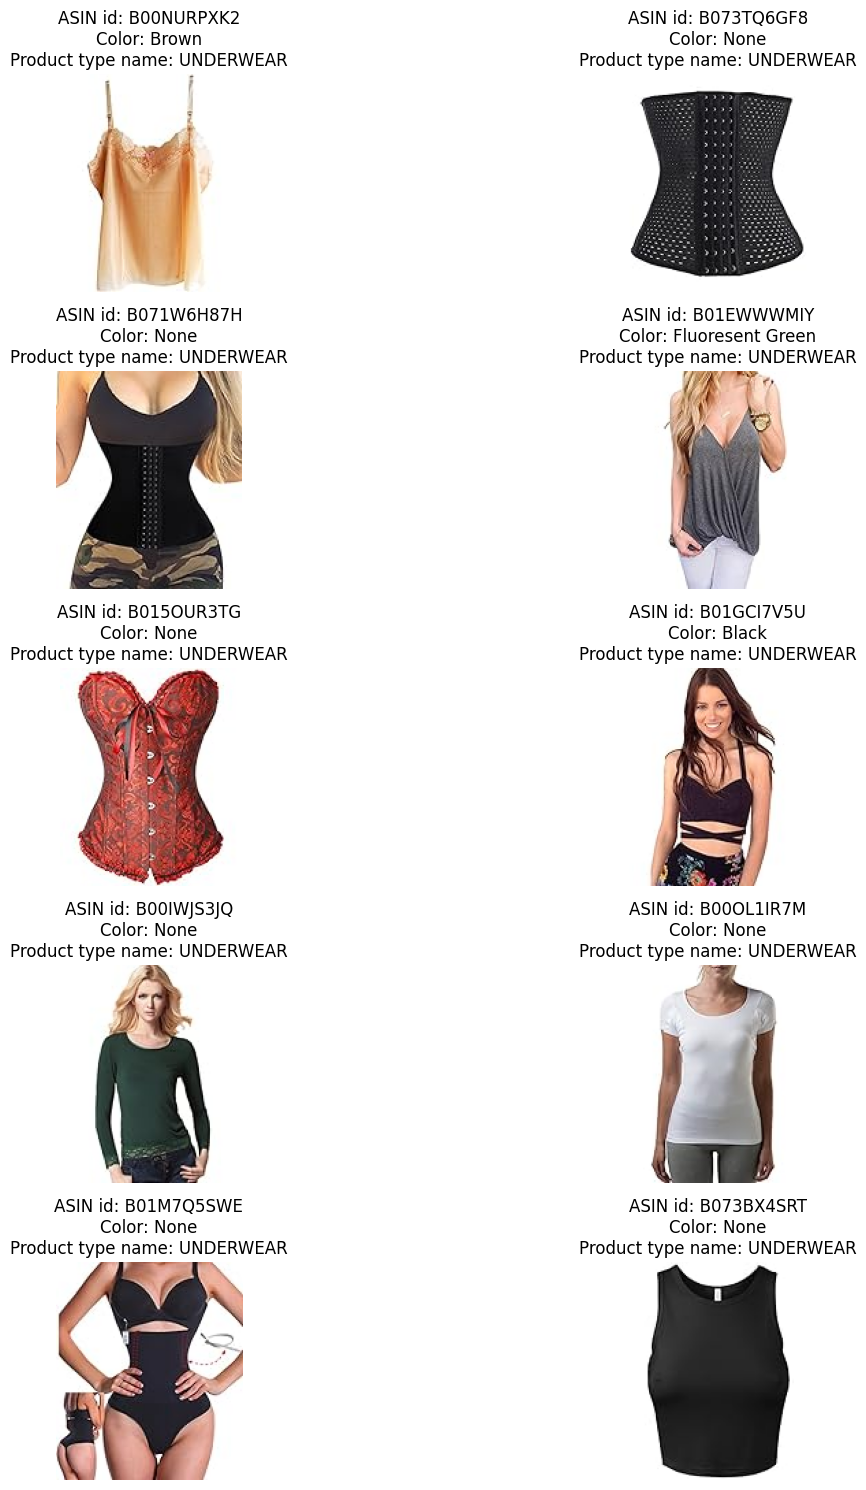

In [66]:
import random as rn
import cv2
import matplotlib.pyplot as plt
import urllib
from PIL import Image

font = cv2.FONT_HERSHEY_PLAIN
INPUT_PATH = 'test'

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
l = 0
data_shirt = data[data['product_type_name']=='UNDERWEAR']
for i in range(5):
    for j in range(2):
        l = rn.randint(0, data_shirt.shape[0] - 1)
        label = data_shirt.iloc[l]['asin']
        
        # Load the image from the URL
        try:
            img_url = data_shirt.iloc[l]['medium_image_url']
            img = Image.open(urllib.request.urlopen(img_url))
            #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Display the image
            ax[i, j].imshow(img)
            
            # Set title (optional)
            ax[i, j].set_title('ASIN id: {}\nColor: {}\nProduct type name: {}'.format(
                str(data_shirt.iloc[l]['asin']), str(data_shirt.iloc[l]['color']), str(data_shirt.iloc[l]['product_type_name'])))
            
            # Hide axes
            ax[i, j].axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")

plt.tight_layout()
plt.show()
